# Introduction

This notebook is designed to be the "exercise" notebook for you to practice defining hierarchical models. We will do this with the finches dataset again.

In [1]:
import pandas as pd
import pymc3 as pm
from data import load_finches_2012
from utils import despine_traceplot

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = load_finches_2012()
df.groupby('species').size()

species
fortis      121
scandens    127
unknown       1
dtype: int64

In [3]:
df.sample(5)

,band,species,beak_length,beak_depth,species_enc
84,21082,fortis,10.9,8.4,0
52,19712,fortis,10.3,8.0,0
57,19782,fortis,9.2,7.6,0
38,19511,fortis,9.9,8.0,0
214,21113,scandens,13.9,9.9,1


In [4]:
df.groupby('species')['beak_depth'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
fortis,121.0,8.605372,0.732570,7.2,8.1,8.5,9.0,11.1
scandens,127.0,9.186220,0.669241,7.7,8.8,9.2,9.6,11.0
unknown,1.0,6.800000,NaN,6.8,6.8,6.8,6.8,6.8


In [5]:
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

**Exercise:** Define a hierarchical model for the finches beak depths. For bonus points, use NumPy-like fancy indexing!

If you'd like a hint, one possible model you can implement is shown below.

![](../images/darwins-finches-hierarchical-model.jpg)

In [6]:
with pm.Model() as beak_depth_model:
    # SD can only be positive, therefore it is reasonable to constrain to >0
    # Likewise for betas.
    sd_hyper = pm.HalfCauchy('sd_hyper', beta=100)
    beta_hyper = pm.HalfCauchy('beta_hyper', beta=100)
    
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=sd_hyper, shape=(3,))
    sd = pm.HalfCauchy('sd', beta=beta_hyper, shape=(3,))
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood distribution for the data.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth'])

Sample from the posterior distribution!

In [7]:
with beak_depth_model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sd_log__, mean_log__, beta_hyper_log__, sd_hyper_log__]
100%|██████████| 2500/2500 [01:59<00:00, 20.92it/s]
The acceptance probability does not match the target. It is 0.9047895774499293, but should be close to 0.95. Try to increase the number of tuning steps.


Visualize the traceplots to check for convergence.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1aa86898>,
      dtype=object)

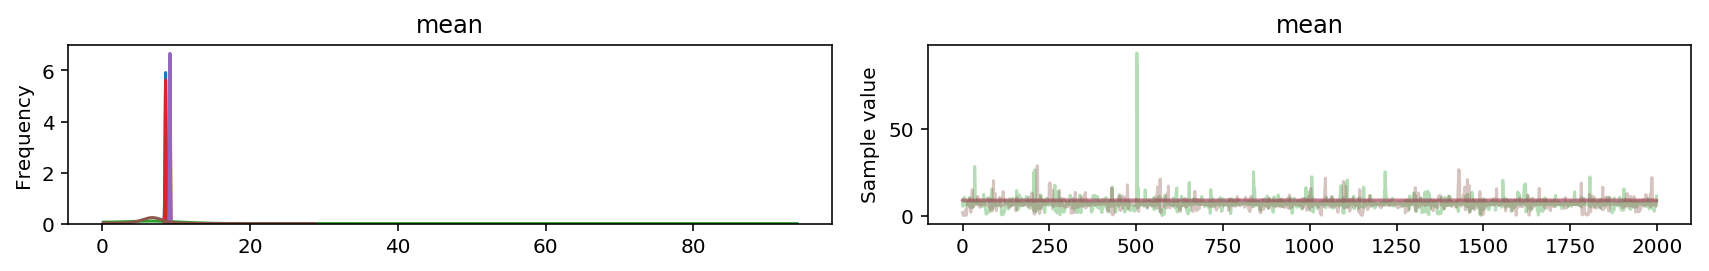

In [8]:
traces = pm.traceplot(trace, varnames=['mean'])
despine_traceplot(traces)

Visualize the posterior distributions using the `plot_posterior` or `forestplot` functions.

Text(0.5,1,'unknown')

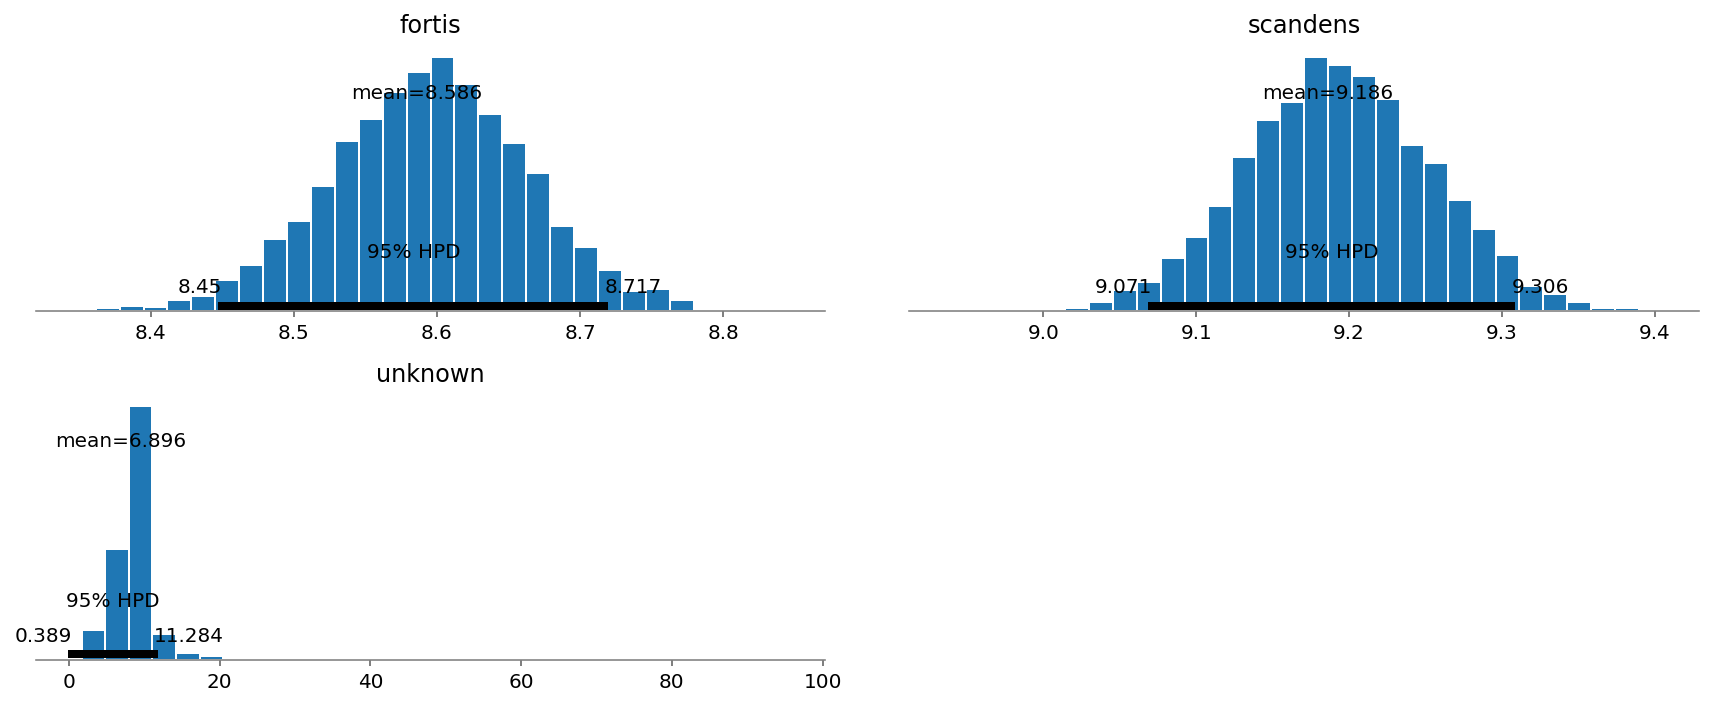

In [9]:
ax1, ax2, ax3 = pm.plot_posterior(trace, varnames=['mean'])
ax1.set_title('fortis')
ax2.set_title('scandens')
ax3.set_title('unknown')

Now, repeat the model specification for beak length.

In [10]:
with pm.Model() as beak_length_model:
    # SD can only be positive, therefore it is reasonable to constrain to >0
    # Likewise for betas.
    sd_hyper = pm.HalfCauchy('sd_hyper', beta=100)
    beta_hyper = pm.HalfCauchy('beta_hyper', beta=100)
    
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=sd_hyper, shape=(3,))
    sd = pm.HalfCauchy('sd', beta=beta_hyper, shape=(3,))
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood distribution for the data.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_length'])

In [11]:
with beak_length_model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sd_log__, mean_log__, beta_hyper_log__, sd_hyper_log__]
100%|██████████| 2500/2500 [05:06<00:00,  8.16it/s]
The acceptance probability does not match the target. It is 0.8465911112298664, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


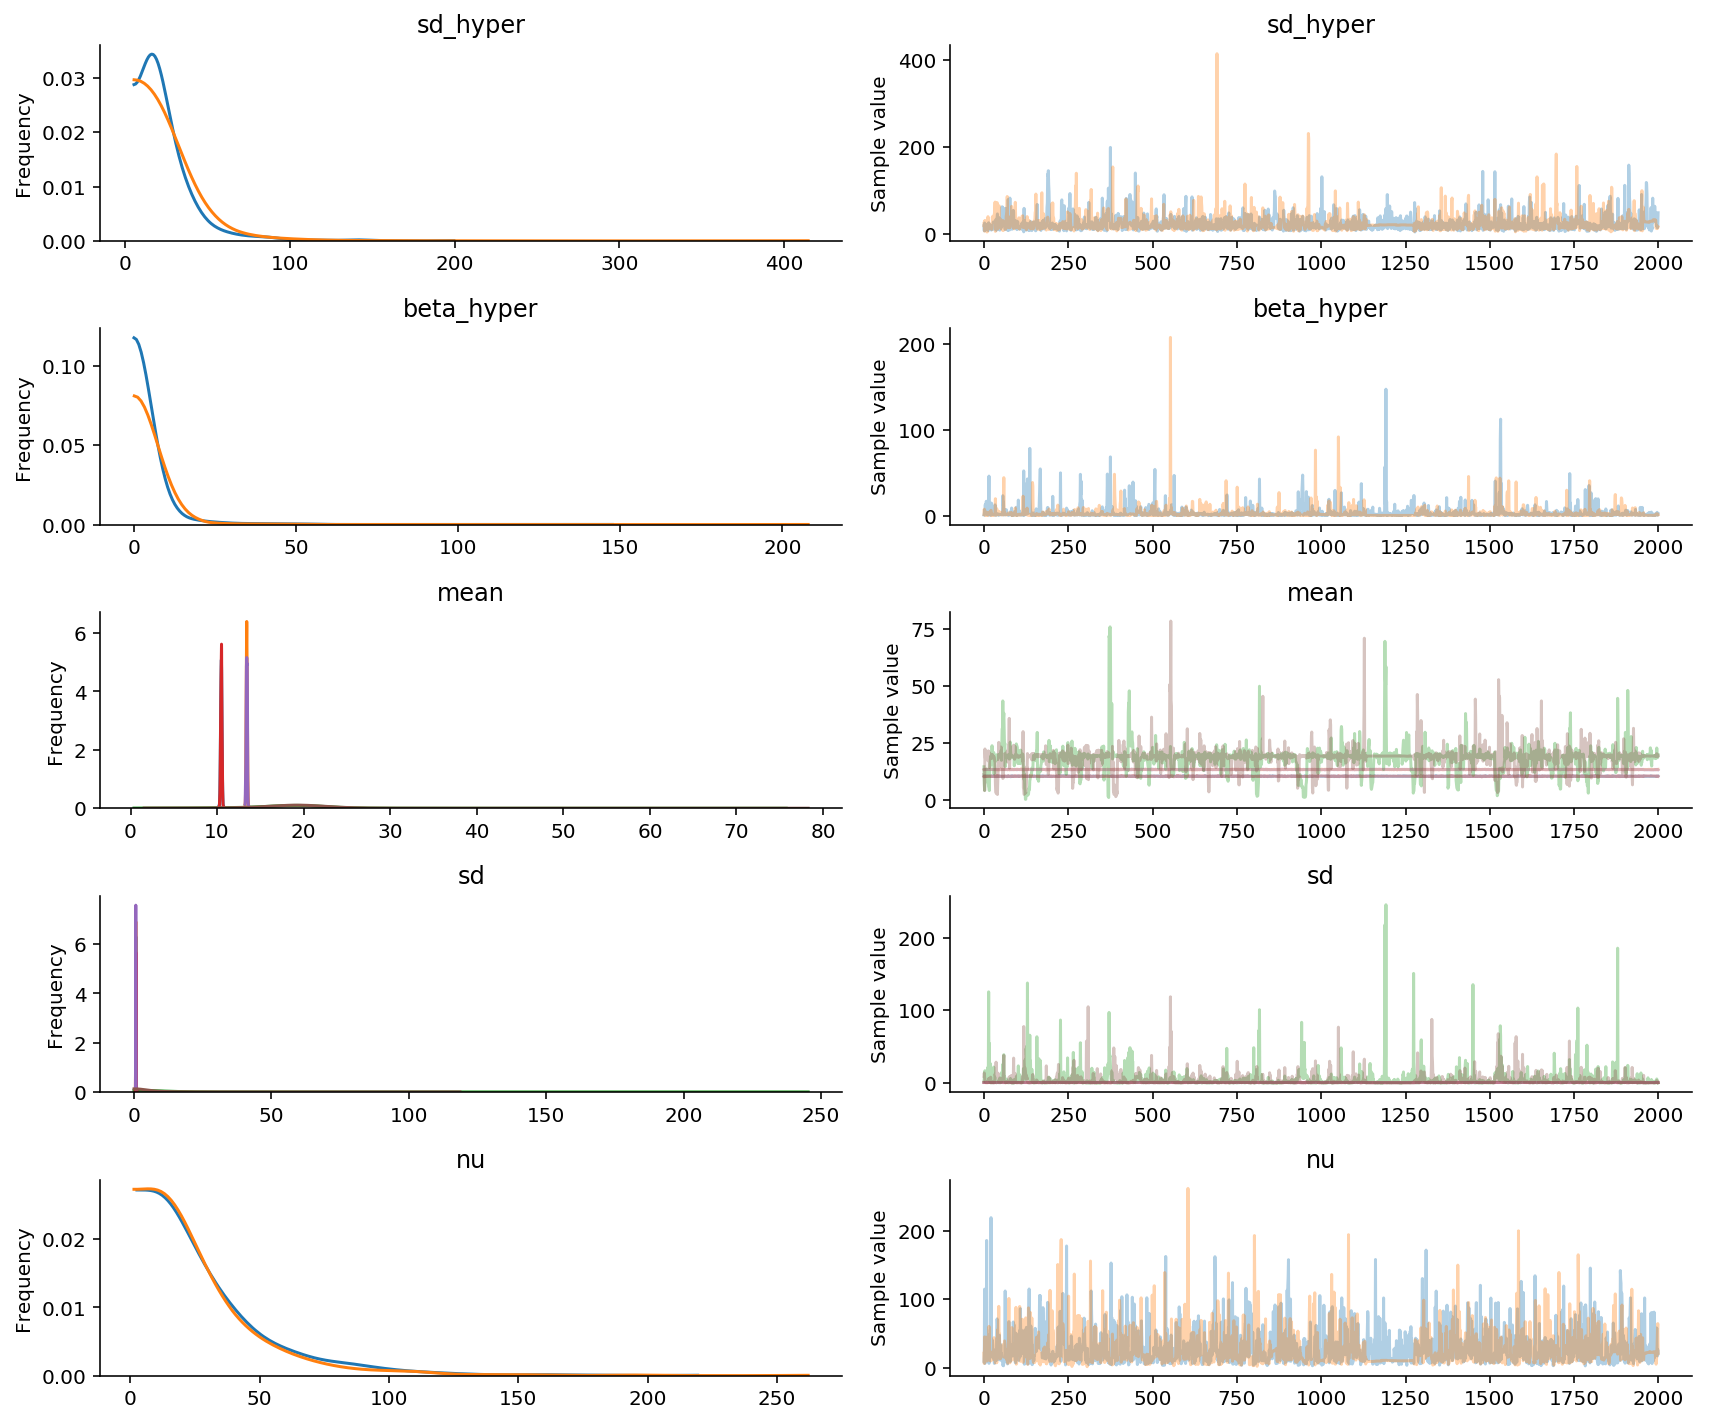

In [12]:
traces = pm.traceplot(trace)
despine_traceplot(traces)

Text(0.5,1,'unknown')

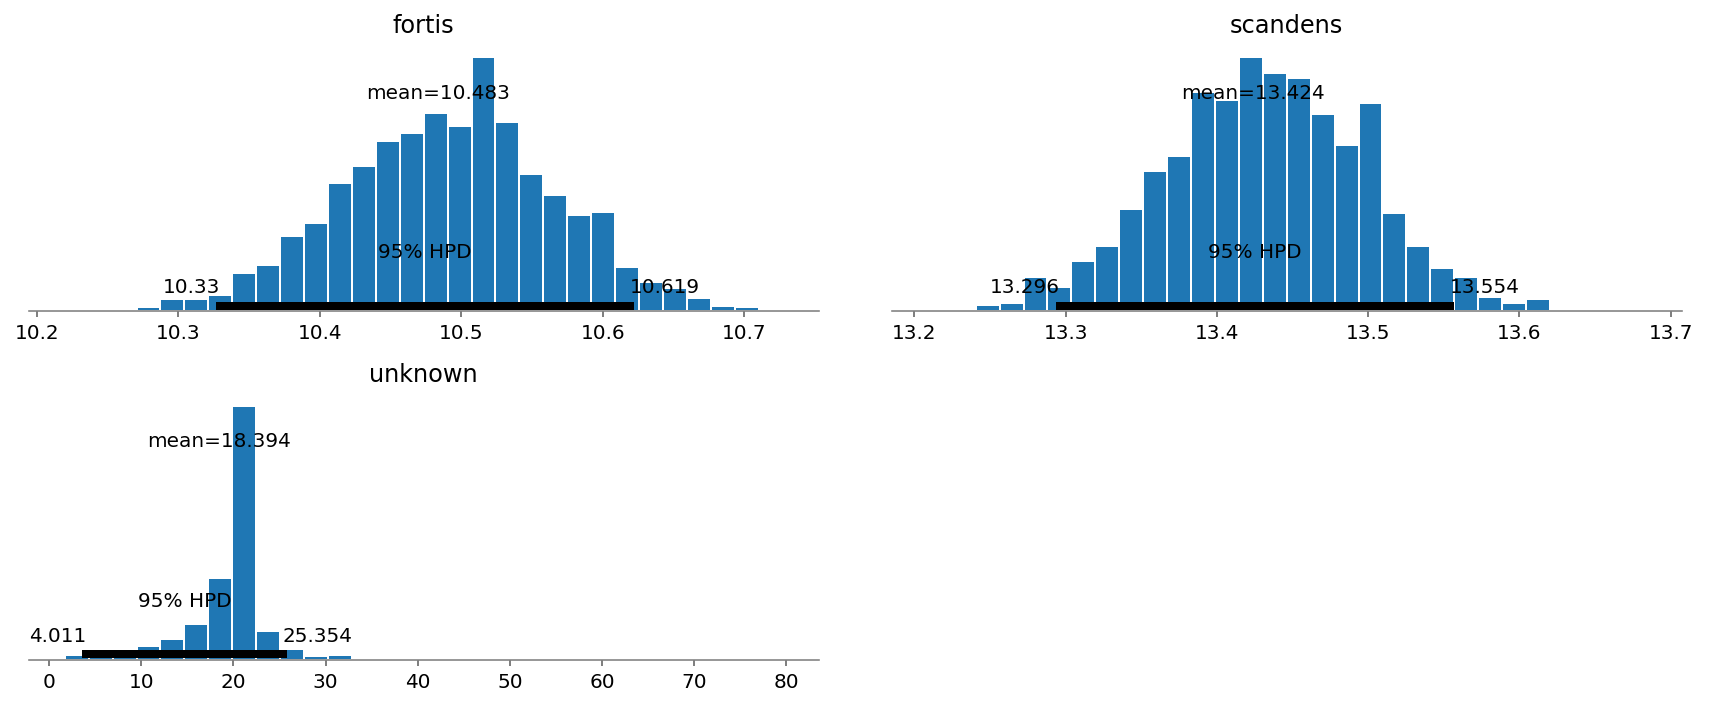

In [13]:
ax1, ax2, ax3 = pm.plot_posterior(trace, varnames=['mean'])
ax1.set_title('fortis')
ax2.set_title('scandens')
ax3.set_title('unknown')

**Discuss:** 

- Are the estimates for the unknown species' beak depth and beak length more reasonable? How so?